# Importation des Librairies Utiles

In [1]:
from datetime import datetime
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pymongo
import numpy as np 
import math
from mpl_toolkits.mplot3d import Axes3D


In [2]:
%store -r nb_composante
%store -r users
%store -r cp_liste

nb_attributes = users.shape[1]

In [3]:
acp = PCA(n_components=nb_composante)
acp_coord = acp.fit_transform(users)

# Clustering

## 3. Détermination le nombre de clusters à conserver
### Méthode du coude

Pour déterminer le nombre optimal de cluster pour notre jeu de donnée, nous pouvons utiliser la méthode du coude et la Silhouette .Nous iterrerons notre algorithme  sur un intervale de nombre de cluster et nous examinerons l'inertie pour chaque nombre de classe en  suivant le principe de coude, de meme nous nous inereserons à au calcul de la sihoullette pour une prise de decision du nombre de clusters definitive

In [5]:
%%time

clusters = {}
n_cluster = range(2,10)
for k in n_cluster:
    start_time = datetime.now()
    print(f"{'-'*30}\n>>>> Start cluster k = {k}: {start_time}")
    result = {}
    
    model = KMeans(n_clusters=k, n_init=10)
    model.fit(users)
    score = silhouette_score(users,model.labels_,sample_size = 100_000)
    #score = multi_core_silhouette(reduced_users,model)
    
    result["model"] = model
    result["silhouette"] = score
    clusters[k] = result
    
    end_time = datetime.now()         
    print(f"End : {end_time}")
    diff_time = end_time - start_time
    print(f"Duration : {diff_time.seconds // 3600}h {(diff_time.seconds // 60) % 60}min {diff_time.seconds % 60}sec ")


------------------------------
>>>> Start cluster k = 2: 2023-06-13 19:31:59.485677
End : 2023-06-13 19:33:37.082660
Duration : 0h 1min 37sec 
------------------------------
>>>> Start cluster k = 3: 2023-06-13 19:33:37.082660
End : 2023-06-13 19:35:17.806368
Duration : 0h 1min 40sec 
------------------------------
>>>> Start cluster k = 4: 2023-06-13 19:35:17.806872
End : 2023-06-13 19:36:51.509756
Duration : 0h 1min 33sec 
------------------------------
>>>> Start cluster k = 5: 2023-06-13 19:36:51.509756
End : 2023-06-13 19:38:26.558749
Duration : 0h 1min 35sec 
------------------------------
>>>> Start cluster k = 6: 2023-06-13 19:38:26.558749
End : 2023-06-13 19:39:52.414251
Duration : 0h 1min 25sec 
------------------------------
>>>> Start cluster k = 7: 2023-06-13 19:39:52.414752
End : 2023-06-13 19:41:26.894699
Duration : 0h 1min 34sec 
------------------------------
>>>> Start cluster k = 8: 2023-06-13 19:41:26.894699
End : 2023-06-13 19:43:01.686141
Duration : 0h 1min 34sec 

In [6]:
score_inertie = [ clusters[k]["model"].inertia_ for k in clusters.keys()]
score_silhouette = [ clusters[k]["silhouette"] for k in clusters.keys()]

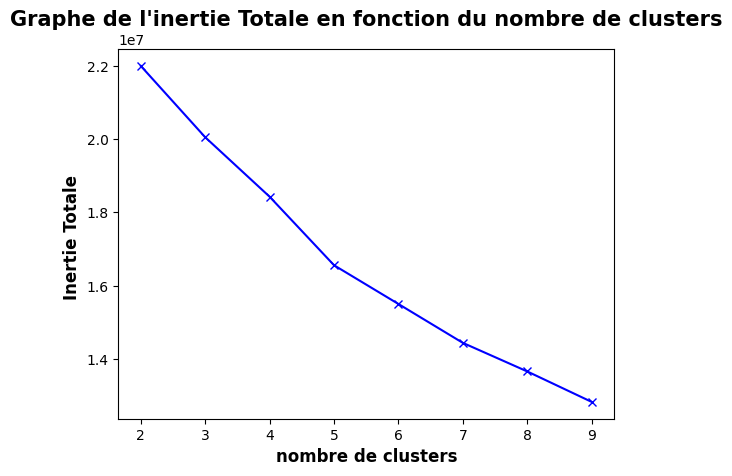

In [7]:
# Graphe de lInertie Total en fonction du nombre de cluster
plt.plot(n_cluster, score_inertie,"bx-")

#Labels
plt.xlabel("nombre de clusters", fontweight = "bold",fontsize = 12)
plt.ylabel("Inertie Totale ", fontweight = "bold",fontsize = 12)

#Titles
plt.title("Graphe de l'inertie Totale en fonction du nombre de clusters", fontweight = "bold", fontsize = 15)


plt.show()

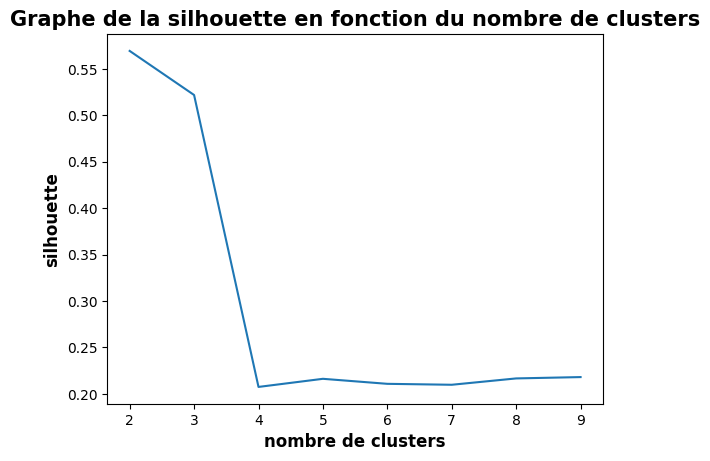

In [8]:
plt.plot(n_cluster, score_silhouette)
plt.xlabel("nombre de clusters", fontweight="bold", fontsize=12)
plt.ylabel("silhouette", fontweight="bold", fontsize=12)
plt.title("Graphe de la silhouette en fonction du nombre de clusters", fontweight="bold", fontsize=15)
plt.show()

On voit que le nombre de clusters optimal est `2` ou `3`. Ici on souhaite séparer les profils en 2 catégories : atypiques et normales. On va donc choisir 2 clusters pour la suite. A la suite de la représentation des 2 clusters, une représentation avec 5 sera également disponible.

In [9]:
def plot_model(model,users_label,elev=None,azim=None):
    labels = set(model.labels_)
    last_col = users_label[:, -1]  # Extract the last column

    unique_vals = np.unique(last_col)  # Get unique values from the last column

    random_rows = []
    num_rows = 2000  # Number of rows to retrieve for each unique value

    for val in unique_vals:
        rows_with_val = np.where(last_col == val)[0]  # Get indices of rows with the current value
        random_indices = np.random.choice(rows_with_val, num_rows, replace=False)  # Randomly choose indices
        random_rows.extend(random_indices)

    selected_rows = users_label[random_rows]  # Retrieve the selected rows

    # Determine the number of combinations
    num_cols = selected_rows.shape[1] - 1
    num_combinations = num_cols * (num_cols - 1) * (num_cols - 2) // 6

    # Create subplots for each combination
    fig, axes = plt.subplots(nrows=num_combinations, ncols=1, figsize=(10, 8 * num_combinations), subplot_kw={'projection': '3d'})

    # Iterate over all possible combinations of three columns
    subplot_idx = 0
    for i in range(num_cols - 2):
        for j in range(i + 1, num_cols - 1):
            for k in range(j + 1, num_cols):
                ax = axes[subplot_idx]
                subplot_idx += 1

                # Plotting the points with the colors
                for label in labels:
                    plotted_values = selected_rows[:,-1] == label
                    ax.scatter(selected_rows[plotted_values, i], selected_rows[plotted_values, j], selected_rows[plotted_values, k], label=label)

                # Setting labels for the axes
                ax.set_xlabel(f'CP{i+1}')
                ax.set_ylabel(f'CP{j+1}')
                ax.set_zlabel(f'{k+1}')
                ax.set_title(f'Graph {subplot_idx} - CP{i+1}*CP{j+1}*CP{k+1}')
                ax.legend()
                
                if(azim and elev):
                    ax.view_init(elev=elev, azim=azim)

    # Adjust the layout of subplots
    plt.tight_layout()

    # Display the plot
    plt.show()
    

# KMeans Avec 2 Clusters

In [10]:
model = clusters[2]["model"]
users_label = np.c_[acp_coord,model.labels_]
print(users_label.shape)

(1843439, 7)


In [11]:
print("Nombre d'individus par label")

for label in set(model.labels_):
    filtered_values = users_label[:,-1] == label
    print(f"{label}: {np.count_nonzero(filtered_values)} - ({np.count_nonzero(filtered_values)/users_label.shape[0]*100:.2f})%")

Nombre d'individus par label
0: 1736213 - (94.18)%
1: 107226 - (5.82)%


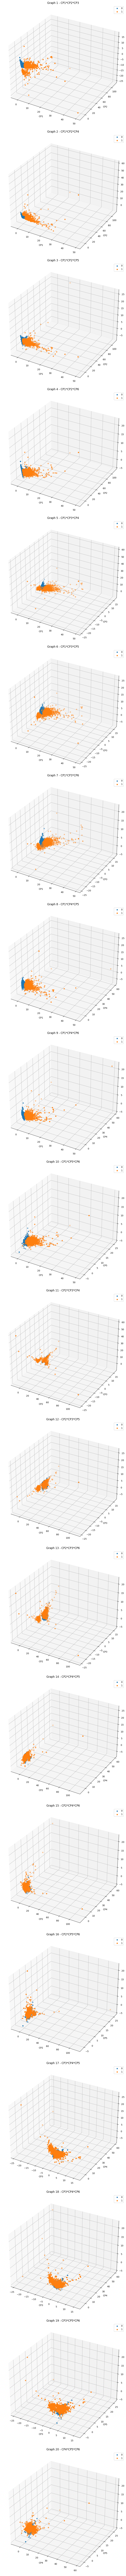

In [12]:
plot_model(model,users_label)

In [13]:
#plot_model(model,users_label,elev=190,azim=45)

In [14]:
users_acp_label = pd.concat((users.reset_index(),pd.DataFrame(acp_coord)), axis=1)
users_acp_label .columns.values[-nb_composante:] = cp_liste[:nb_composante]
users_acp_label ["label_kmeans"] = model.labels_

Text(0.5, 1.0, 'valeures moyenne des composantes')

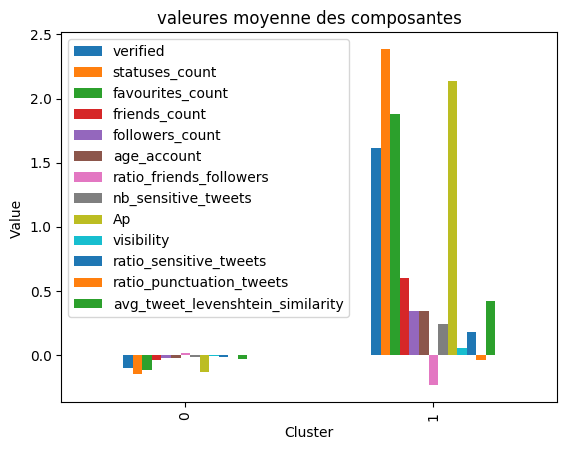

In [15]:
xgb = users.groupby(model.labels_).mean()

#Plot
xgb.plot(kind = "bar")

#Labels
plt.xlabel("Cluster")
plt.ylabel("Value ")

#Title
plt.title("valeures moyenne des composantes")

In [16]:
client = pymongo.MongoClient("mongodb://localhost:27017")
db = client["Tweet"]
user_kmeans_collection = db["users_kmeans_labeled"]
user_kmeans_collection.drop()

In [17]:
data = users_acp_label.to_dict(orient="records")
user_kmeans_collection.insert_many(data)